# <font color=black> Time-series features: BrainDyn and SpiDyn </font>
<hr style="border:1px solid black">

## <font color=#B14263> Imports

In [1]:
import sys,json,glob, re
#os, 
import pandas as pd
import numpy as np


main_dir='/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/2025_brsc_aging_project/'
sys.path.append(main_dir+'/code/')

from connectivity.ts_features import FeatureSets
from connectivity.seed_to_target import Seed2target

#statistics
from statsmodels.stats.multitest import multipletests
from brsc_statistics import Statistics 
from sim_matrix import Matrix

#plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from plotting import Plotting



config_file=main_dir + '/config/analyses/brsc_functional.json'


%matplotlib inline
%load_ext autoreload
%autoreload 2

### load config file
with open(config_file) as config_f:
    config = json.load(config_f) # load config info
stat_func=Statistics(config=config,ana_dir="",analysis="")


<hr style="border:1px solid black">

## <font color=#B14263> A. Brain time series features 
##### Initialize the analysis and load the timeseries

In [2]:
IDs=config["participants_IDs_ALL"]
structure="brain"
ts_features=FeatureSets(config,IDs=IDs,structure=structure)
seed2seed=Seed2target(config_file,IDs=IDs,ana="ts_features",seed_kind="atlas",structure=[structure],verbose=0) # initialize the function


Feature analyses output directory: /cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project//figures/f02_functional_sc/preprint2025/features/brain/schaefer200_cobra//

Analyzing 67 participant(s)



#### <font color=#B14263> A.2 Timeseries extraction
So far the timeseries are extracted in the seed2seed function but it could be implement later in the feature function

In [3]:
timeseries,timeseries_labels,labels_list=seed2seed.extract_atlas_data(standardize=False,redo=False,n_jobs=6)

The timeseries were already extracted, loading them ...


#### <font color=#B14263> A.3 Compute features calculation
/!\ Brain alff should first be run using Fig02a_SpiDyn-BrainDyn_alff.ipynb notebook

In [4]:
alff_dir=config["project_dir"] + config["alff"]["analysis_dir"]["brain"] +"/alff/slow5/1_first_level/metric/"
alff_df=[];alff=[]
for ID_nb, ID in enumerate(IDs):
    alff_file= glob.glob(alff_dir + "/sub-" + ID + "_alff_schaefer200_cobra.csv")[0]
    alff_df.append(pd.read_csv(alff_file))
    alff.append(np.array(alff_df[ID_nb]["alff"]))

df_features,df_features_z=ts_features.compute_pychatch24(ts_data=timeseries['brain']['zmean'],
                                                         seed_labels=labels_list,
                                                         add_features={"alff": alff},
                                                         scaling_method="robust_sigmoid",#scaling_method="robust_sigmoid",
                                                         redo=False)

#### <font color=#B14263> A.4 Compute similarity matrices

In [5]:
output_dir= config["project_dir"] +config["ts_features"]["analysis_dir"][structure]
ana_matrix=Matrix(config=config,IDs=IDs,output_dir=output_dir)
selected_cols = np.r_[9,11:12,13:18,19:20,22:25,26:34]

col_selected = df_features_z.columns[selected_cols]

all_sim_matrix, mean_sim_matrix,df_sim=ana_matrix.compute_similarity_matrix(data_df=df_features,column_labels=col_selected ,atlas_labels=labels_list,
                                                                            tag="_Schaefer200Cobra",structure="brain",
                                                                            scaling_method="robust_sigmoid",redo=False)
df_sim_mean=df_sim.groupby(['seed1', 'seed2', 'labels1', 'labels2',"network_labels","betwith_labels"], as_index=False,sort=False)["sim"].mean()

/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project//figures/f02_functional_sc/preprint2025/features/brain/schaefer200_cobra/1_first_level/sim_matrix/sim_matrix_df_Schaefer200Cobra.csv


/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/2025_brsc_aging_project//code/sim_matrix.py:126: RuntimeWarning: Mean of empty slice
  mean_sim_matrix = np.nanmean(np.stack(all_sim_matrix), axis=0)


In [6]:
#---- Create sub df including sensorimotor region only
df_SomMot_mean = df_sim_mean[df_sim_mean['seed1'].str.contains("M1|S1|Cerebellum|Subcortical") & df_sim_mean['seed2'].str.contains("M1|S1|Cerebellum|Subcortical")].reset_index(drop=True)
df_SomMot = df_sim[df_sim['seed1'].str.contains("M1|S1|Cerebellum|Subcortical") & df_sim['seed2'].str.contains("M1|S1|Cerebellum|Subcortical")].reset_index(drop=True)
SomMot_list = [label for label in labels_list if re.search(r"M1|S1|Cerebellum|Subcortical", label)]
network_SomMot_list = [('L' if 'LH' in x.split('_')[0] else 'R') + ' ' + x.split('_')[1] for x in SomMot_list] # list of the R or L network name for each roi
networks_list = [('L' if 'LH' in x.split('_')[0] else 'R') + ' ' + x.split('_')[1] for x in labels_list] # list of the 17 networks corresponding to each roi


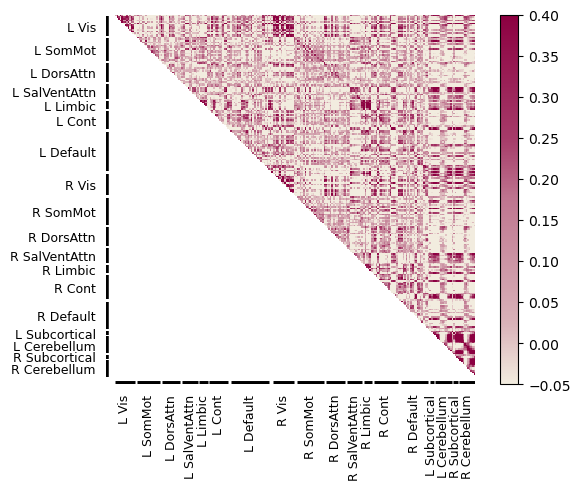

In [7]:
colors = ["#F2ECDF","#D9B1B8","#CC94A4","#BF7690","#A63B69","#991E55","#8C0041"]  # green
config_file="/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/2024_brsc_aging_project/config/06_sc_alff.json"
plot=Plotting(config_file,output_dir)
custom_cmap = LinearSegmentedColormap.from_list("my_colormap", colors)
plot.plot_heatmap(matrix=df_sim,
                  networks=networks_list,
                      networks_y=networks_list,
                      vmax=0.4,vmin=-0.05,
                      cmap=custom_cmap,#half="upper",
                      index_raw='seed1',index_col='seed2',metric='sim',
                  xlabels=True,ylabels=True,
                       output_f=output_dir + '/figures/FC_matrix_brain.pdf',
                      save=False)
plt.show()

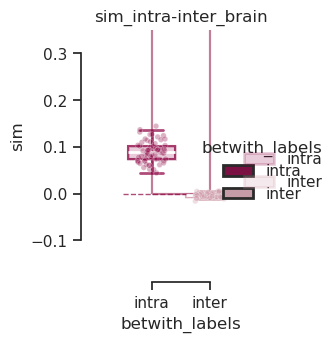

In [8]:
mean_SomMot_betwith=df_SomMot.groupby(["IDs","age","sex","betwith_labels"], sort=False)[["sim"]].mean().reset_index()
mean_betwith=df_sim.groupby(["IDs","age","sex","betwith_labels"], sort=False)[["sim"]].mean().reset_index()


plot.boxplots(df=mean_betwith,
              x_data="betwith_labels",x_order=["intra","inter"],
                  indiv_values=True,#invers_axes=True,
                  palette=["#8C0041","#CC94A4"],#output_dir=config['main_dir'] + config['analysis_dir']['spinalcord'] + '/figures/',
                  #output_tag='corr_' + group_name,
              height=3,aspect=0.6,
                  y_data="sim",
              ymin=-0.1, ymax=0.35,
              output_dir=output_dir + "/figures/",
              output_tag="sim_intra-inter_brain",
              save=False)
plt.show()

<hr style="border:1px solid black">

### <font color=#B14263> C. Link with spinal cord age related changes

In [9]:
# Load spinal cord data
sc_file=config["project_dir"] +config["ts_features"]["analysis_dir"]["spinalcord"] + "/2_second_level/catch24/n67_spinalcord_catch24.csv"
all_temp_sc = pd.read_csv(glob.glob(sc_file)[0])
temp_sc=all_temp_sc.groupby(['IDs', 'age', 'sex', 'groups',"rois","ventro_dorsal"], as_index=False)[col_selected].mean()
temp_sc["networks"]=temp_sc["ventro_dorsal"]
df_reduced=df_features.groupby(['IDs', 'age', 'sex', 'groups',"networks"], as_index=False)[col_selected].mean()
df_roi_reduced=df_features.groupby(['IDs', 'age', 'sex', 'groups',"rois","networks"], as_index=False)[col_selected].mean()

#group brain and spinal cord df
temp_brsc=pd.concat((df_reduced,temp_sc),axis=0)
temp_roi_brsc=pd.concat((df_roi_reduced,temp_sc),axis=0)

In [10]:
from statsmodels.stats.multitest import multipletests
df_reduced = df_features.groupby(['IDs', 'age', 'sex', 'groups',"networks"], as_index=False)[col_selected].mean()
temp_brsc=pd.concat((df_reduced,temp_sc),axis=0)
df_mean_metrics={};
mean_results = [];roi_results=[];signif_feature=[]

for metric_nb, sub_metric in enumerate(col_selected): 
    df_mean_metrics[sub_metric]={}
    signed_r2, p_age,p_sex, beta_age, beta_sex, stat_age,stat_sex=stat_func.signed_partial_r2(df=temp_brsc.dropna(),y=sub_metric,predictor="age",covariates=["sex"],random=None)
    mean_results.append({"sub_metric": sub_metric,"signed_r2": signed_r2,"p_age": p_age,"beta_age": beta_age,"beta_sex": beta_sex,"tvalue_age": stat_age,"tvalue_sex": stat_sex})
    
    for roi in np.unique(temp_brsc["networks"]):
        df_roi_metrics=temp_brsc[temp_brsc["networks"]==roi]
        signed_r2_2, p_age2,p_sex2, beta_age2,beta_sex2, stat_age2,stat_sex2=stat_func.signed_partial_r2(df=df_roi_metrics,y=sub_metric,predictor="age",covariates=["sex"],random=None)
        if p_age2<0.05:
            signif_feature.append(sub_metric)
            print(sub_metric +" " + roi + " p_age:" + str(p_age2))
        roi_results.append({"sub_metric": sub_metric,"networks":roi,"signed_r2": signed_r2_2,"p_age": p_age2,"p_sex": p_sex2,"beta_age": beta_age2,"beta_sex": beta_sex2,"tvalue_age": stat_age2,"tvalue_sex": stat_sex2})
        

mean_result_df= pd.DataFrame(mean_results)  
roi_results_df= pd.DataFrame(roi_results)

print(" ")
for roi in np.unique(df_reduced["networks"]):
    print(roi + " absolute mean t-value: " + str(np.round(np.mean(np.abs(roi_results_df[(roi_results_df["networks"]==roi)]["tvalue_age"])),3)))

# ---- FDR correction
p_age = roi_results_df["p_age"].values; p_sex = roi_results_df["p_sex"].values
reject, page_corrected, _, _ = multipletests(p_age, method='fdr_bh'); reject, psex_corrected, _, _ = multipletests(p_sex, method='fdr_bh')
roi_results_df["page_fdr"] = page_corrected; roi_results_df["psex_fdr"] = psex_corrected



acf_timescale Control p_age:0.025517705249616194
acf_timescale DorsAttn p_age:0.043087463244389196
acf_timescale SomMot p_age:0.025745605170498297
acf_timescale dorsal p_age:6.81156044905511e-05
acf_timescale ventral p_age:0.008455878698662623
ami2 Cereb p_age:0.03289244473281844
trev VentAttn p_age:0.02104495907085083
transition_matrix SomMot p_age:0.03965506921640001
embedding_dist Control p_age:0.019370651459123995
embedding_dist SomMot p_age:0.003062033019568663
embedding_dist dorsal p_age:0.013473548112677442
embedding_dist ventral p_age:0.018666514600382635
outlier_timing_neg ventral p_age:0.03301130308961333
centroid_freq dorsal p_age:0.00014519896497795128
centroid_freq ventral p_age:0.007595397947362974
entropy_pairs Control p_age:0.001871947936087282
entropy_pairs DorsAttn p_age:0.008007408768274145
entropy_pairs SomMot p_age:0.003268376268524652
entropy_pairs dorsal p_age:0.021364948245899
dfa Default p_age:0.04576037707245253
low_freq_power dorsal p_age:0.000116578364467798

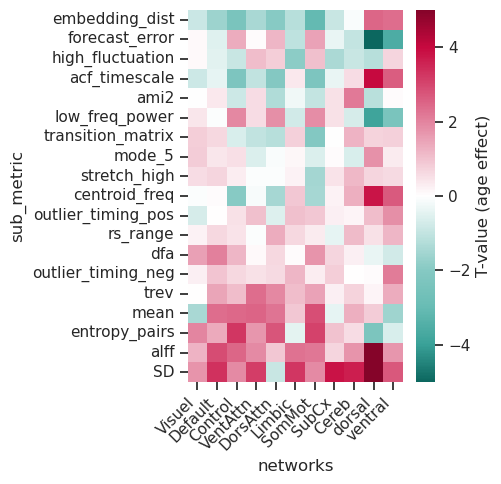

In [11]:
import seaborn as sns
pivot = roi_results_df.pivot(index="sub_metric", columns="networks", values="tvalue_age")
#feat_order=["MTR","T2s_vx_gm","T2s_vx_wm","FA","RD","AD","MD"]
colors = ["#0C675F","#3AA198","#68BCB4","#86C9C3","#C3E4E1","#FFFFFF","#F1C2CF","#E3849F","#D5476F","#C7093F","#850429"]  # blue → white → red
custom_cmap = LinearSegmentedColormap.from_list("my_colormap", colors)

feat_order = pivot.mean(axis=1).sort_values(ascending=True).index.tolist()
# Pivot: rows = sub-metrics, columns = networks, values = t-values
pivot = roi_results_df.pivot(index="sub_metric", columns="networks", values="tvalue_age")


feat_order = pivot.mean(axis=1).sort_values().index.tolist()
pivot = pivot.reindex(index=feat_order)

network_order = ['Visuel', 'Default','Control', 'VentAttn', 'DorsAttn', 'Limbic',
                 'SomMot', 'SubCx', 'Cereb', 'dorsal', 'ventral']
pivot = pivot.reindex(columns=network_order)

# Plot
plt.figure(figsize=(5, 5))
sns.heatmap(pivot,cmap=custom_cmap,center=0,vmin=-5, vmax=5,cbar_kws={'label': 'T-value (age effect)'})

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Optional: save
plt.savefig(output_dir + '/figures/age_effect_tvalues_networks.pdf', format='pdf')

plt.show()

## Gradients

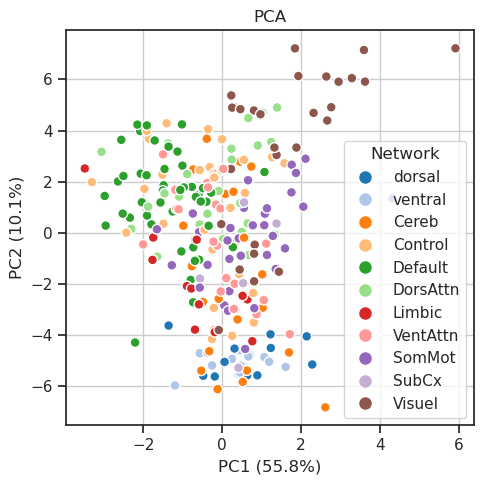

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


df_net = temp_roi_brsc.iloc[:, 0:24].groupby('rois')[col_selected[:-1]].mean()
roi_network_map = temp_roi_brsc.iloc[:, 0:24].groupby('rois')['networks'].first()

scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_net),
    index=df_net.index,
    columns=df_net.columns
)

pca = PCA(n_components=10)
pca_coords = pca.fit_transform(df_scaled)

unique_networks = roi_network_map.unique()
palette = sns.color_palette('tab20', len(unique_networks))
color_map = dict(zip(unique_networks, palette))
colors = roi_network_map.map(color_map)

plt.figure(figsize=(5, 5))
plt.scatter(pca_coords[:, 1], pca_coords[:, 0], s=50, c=colors, edgecolor='w')

# Annotation uniquement pour le réseau choisi
network_to_annotate = ''
indices_to_annotate = roi_network_map[roi_network_map == network_to_annotate].index

for i, roi in enumerate(df_scaled.index):
    if roi in indices_to_annotate:
        plt.text(pca_coords[i, 0], pca_coords[i, 1], roi, fontsize=9, color='black', fontweight='bold')

handles = [plt.Line2D([0], [0], marker='o', color='w', label=net,
                      markerfacecolor=color_map[net], markersize=10)
           for net in unique_networks]
plt.legend(handles=handles, title='Network')

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA")
plt.grid(True)
plt.tight_layout()
plt.show()


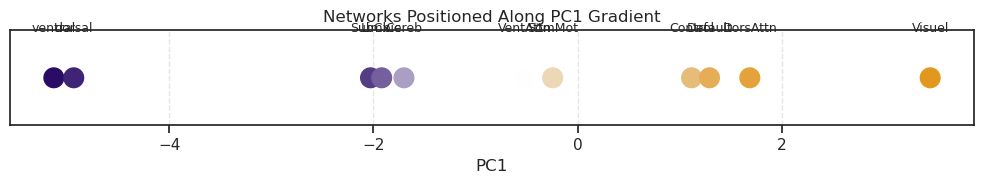

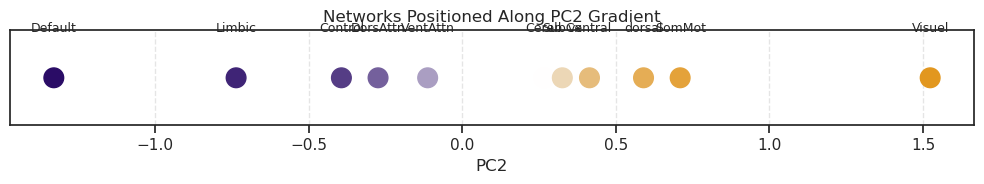

In [14]:
colors = ["#0C675F","#3AA198","#68BCB4","#86C9C3","#C3E4E1","#FFFFFF",]  # blue → white → red
colors = ["#2A0C66","#452B7A","#60498D","#9586B3","#FFFFFF","#e7cda4","#E5B262","#E4A541","#E2971F"]  # blue → white → red

custom_cmap = LinearSegmentedColormap.from_list("my_colormap", colors)

# PCA with 10 components
pca = PCA(n_components=10)
pca_coords = pca.fit_transform(df_scaled)

# Add network info
pc_columns = [f'PC{i+1}' for i in range(10)]
pca_df = pd.DataFrame(pca_coords, index=df_scaled.index, columns=pc_columns)
pca_df['network'] = roi_network_map.loc[df_scaled.index].values

# Compute centroid per network
group_network_centroids = pca_df.groupby('network')[pc_columns].mean().reset_index()
group_network_centroids_10D = pca_df.groupby('network')[pc_columns].mean().reset_index()

def plot_pc_gradient(component: str, df: pd.DataFrame, cmap=custom_cmap,save=False):
    # Sort networks by that component
    sorted_df = df.sort_values(component).reset_index(drop=True)
    
    # Create gradient colors
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(sorted_df)))
    
    # Plot
    plt.figure(figsize=(10, 2))
    plt.scatter(sorted_df[component], np.zeros_like(sorted_df[component]), c=colors, s=200)

    for i, row in sorted_df.iterrows():
        plt.text(row[component], 0.05, row['network'], ha='center', va='bottom', fontsize=9)

    plt.yticks([])
    plt.xlabel(component)
    plt.title(f'Networks Positioned Along {component} Gradient')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    if save:
        plt.savefig(f"{output_dir}/figures/network_gradient_{component}.pdf", dpi=300, bbox_inches='tight')  # or use .pdf, .svg etc.
    plt.show()


# Plot for PC1, PC2
for pc in ['PC1', 'PC2']:
    plot_pc_gradient(pc, group_network_centroids,save=True)
